# HW05: Practice with algorithm selection, assessment, hyperparameter tuning, multiclass and one-class classification, and imbalanced data.

[Please put your name and NetID here.]

##### Hello Students:
 Start by downloading HW05.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class, office hours, or piazza. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in:
  - HW03.ipynb to Canvas's HW03.ipynb assignment
  - HW03.html to Canvas's HW03.html assignment
  - As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. One-class classification (outlier detection)

### 1(a) There is an old gradebook at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [3]:
df = pd.read_table('http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt', sep = '\s+', skiprows = 12)
df

,Exam1,Exam2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,HW6,HW7,HW8,HW9,Percentage,Rank,Percentile,percentageGrade,percentileGrade,Grade
0,121,120,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,3.0,4.0,97.13,391,99.7,A,A,A
1,119,116,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,4.0,3.5,95.22,390,99.5,A,A,A
2,125,109,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.0,4.0,4.0,2.5,94.90,389,99.2,A,A,A
3,117,115,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,3.5,4.0,94.27,387,98.7,A,A,A
4,110,122,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,4.0,4.0,94.27,387,98.7,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,94,0,4,4.0,4.0,3.64,2.4,4,4.0,4.00,...,4.0,3.0,2.5,3.0,49.09,5,1.0,F,F,F
387,0,84,4,4.0,3.7,4.00,0.0,0,4.0,4.00,...,4.0,4.0,4.0,3.0,45.91,4,0.8,F,F,F
388,0,82,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.5,4.0,0.0,4.0,44.75,3,0.5,F,F,F
389,84,0,4,4.0,1.0,2.12,3.2,0,0.5,1.38,...,0.0,0.0,0.0,0.0,36.21,2,0.3,F,F,F


### 2(a) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, \text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So, instead, I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [4]:
X = df[['Exam1', 'Exam2']]
X = (X*100) / 125
clf = mixture.GaussianMixture(n_components=1)
clf.fit(X)
print(f'the means are {clf.means_[0]}')
print(f'the covariances are {clf.covariances_}')

the means are [82.81329923 71.01176471]
the covariances are [[[155.51123078  73.02961336]
  [ 73.02961336 180.87014392]]]


### 2(b) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

In [5]:
samples = np.exp(clf.score_samples(X)) 
threshold = np.quantile(np.exp(clf.score_samples(X)), .02)
empty = []

# go through each element in arr
for i in samples:
  # if the element is higher than 42, set the value to True, otherwise False:
  if i < threshold:
    empty.append(True)
  else:
    empty.append(False)

datapoints = samples[empty]
datapoints

array([7.79145846e-07, 8.90693281e-13, 1.93199507e-12, 1.60208886e-10,
       4.20525985e-15, 6.11359183e-15, 4.73135236e-10, 8.28160126e-15])

/Users/reidsroda/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, '(Exam1, Exam2) pairs')

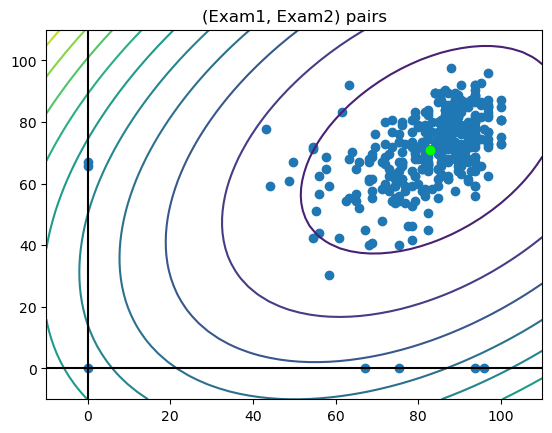

In [6]:
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.axhline(0, color='black', label = 'Exam1')
plt.axvline(0, color='black', label = 'Exam 2')
plt.scatter(X.Exam1, X.Exam2)
plt.scatter(clf.means_[0][0],clf.means_[0][1], color = 'lime')
plt.title('(Exam1, Exam2) pairs')

### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

In [8]:
#Any points where they recieved a score of 70 or lower on one of the two exams

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [9]:
df = pd.DataFrame([[50,100]])
np.exp(clf.score_samples(df)) < threshold
print('pdf value is lower than threshold, this is an outlier')

pdf value is lower than threshold, this is an outlier


/Users/reidsroda/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


## 3. Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [10]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, weights=[0.980, 0.020],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[973  27]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.027; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[486  14]
np.mean(y_train)=0.028.
np.bincount(y_test)=[487  13].
np.mean(y_test)=0.026.
